In [1]:
import tensorflow_datasets as tfds
import sign_language_datasets.datasets
from sign_language_datasets.datasets.config import SignDatasetConfig

import itertools

2024-02-19 13:27:50.259008: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 13:27:52.237347: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 13:27:52.253829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 13:27:57.521562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DATA_DIR = "./datasets"

In [3]:
config = SignDatasetConfig(name="rwth_phoenix2014_t_poses", version="3.0.0", include_video=False, include_pose="holistic")
rwth_phoenix2014_t = tfds.load(name='rwth_phoenix2014_t', builder_kwargs=dict(config=config), data_dir=DATA_DIR)

In [4]:
for datum in itertools.islice(rwth_phoenix2014_t["train"], 0, 5):
  print((datum.keys()))
  print(datum['pose']['data'].shape)
  print(datum['gloss'].numpy().decode('utf-8'))
  print(datum['text'].numpy().decode('utf-8'))
  print()

dict_keys(['gloss', 'id', 'pose', 'signer', 'text'])
(47, 1, 543, 3)
GUT ABEND LIEB ZUSCHAUER
guten abend liebe zuschauer

dict_keys(['gloss', 'id', 'pose', 'signer', 'text'])
(56, 1, 543, 3)
BERG DAZU SCHNEE
im bergland fällt zunehmend schnee

dict_keys(['gloss', 'id', 'pose', 'signer', 'text'])
(70, 1, 543, 3)
UNWETTER WEHEN
und der wind weht auch noch kräftig aus west bis nordwest

dict_keys(['gloss', 'id', 'pose', 'signer', 'text'])
(99, 1, 543, 3)
WIE-AUSSEHEN IN-KOMMEND MONTAG BIS MITTWOCH WIE-IMMER
die aussichten von montag bis mittwoch ändert sich das wetter kaum

dict_keys(['gloss', 'id', 'pose', 'signer', 'text'])
(123, 1, 543, 3)
BERG HOCH KOENNEN QUELL WOLKE NAH REGION KOENNEN VERDICHTEN
über dem bergland können sich einzelne quellwolken zeigen in küstennähe gibt es auch mal dichtere wolken



In [13]:
lengths = []
texts = []

for datum in rwth_phoenix2014_t["train"]:
  lengths.append(datum['pose']['data'].shape[0])
  texts.append(datum['text'].numpy().decode('utf-8'))

In [14]:
import pandas as pd


lengths_df = pd.Series(lengths)
lengths_df.describe(percentiles=[.75, .9, .95, .99])

count    7096.000000
mean      116.594419
std        49.859426
min        16.000000
50%       112.000000
75%       144.000000
90%       182.000000
95%       208.000000
99%       259.000000
max       475.000000
dtype: float64

<AxesSubplot:>

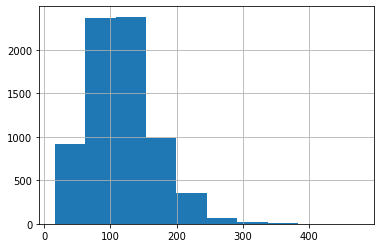

In [15]:
lengths_df.hist()

In [53]:
# Load model directly
from transformers import AutoTokenizer, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-german-cased")
bert_german = TFAutoModel.from_pretrained("google-bert/bert-base-german-cased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [46]:
tokenized_sequences = tokenizer(texts, padding=True)

In [47]:
texts[1]

'im bergland fällt zunehmend schnee'

In [52]:
tokenized_sequences[1]

Encoding(num_tokens=69, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing

embedding_dim = 1629
seq_length = 475
num_heads = 8
ff_dim = 1024
num_transformer_blocks = 4
mlp_units = [512]
dropout = 0.1
mlp_dropout = 0.4

# Pretrained text model
input_text = Input(shape=(69,), dtype=tf.int32)
text_representation = bert_german(input_text)

# Transformer Encoder Layer
transformer_encoder = tf.keras.layers.TransformerEncoder(
    units=embedding_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    dropout=dropout
)

input_embeddings = Input(shape=(seq_length, embedding_dim))
x = transformer_encoder(input_embeddings)

# Global Average Pooling para reducir la longitud de la secuencia
x = GlobalAveragePooling1D()(x)

# Capas de la red densa (MLP)
for dim in mlp_units:
    x = Dense(dim, activation="relu")(x)
    x = Dropout(mlp_dropout)(x)

output_layer = Dense(embedding_dim, activation="linear")(x)
model = Model(inputs=[input_text, input_embeddings], outputs=output_layer)

model.compile(optimizer='adam', loss='mse')

model.summary()


AttributeError: module 'tensorflow.keras.layers' has no attribute 'TransformerEncoder'